In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.6 MB/s eta 0:00:00


In [2]:
import datetime
import os
from typing import Callable, Optional
import pandas as pd
from sklearn import preprocessing
import numpy as np
import torch
import torch_geometric
from torch_geometric.data import (
    Data,
    InMemoryDataset
)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv("/content/drive/MyDrive/HI-Small_Trans.csv")

In [23]:
df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0


In [5]:
df.shape

(5078345, 11)

In [6]:
df.dtypes

,0
Timestamp,object
From Bank,int64
Account,object
To Bank,int64
Account.1,object
Amount Received,float64
Receiving Currency,object
Amount Paid,float64
Payment Currency,object
Payment Format,object


In [7]:
print(df.isnull().sum())

Timestamp             0
From Bank             0
Account               0
To Bank               0
Account.1             0
Amount Received       0
Receiving Currency    0
Amount Paid           0
Payment Currency      0
Payment Format        0
Is Laundering         0
dtype: int64


# Exploratory Data Analysis:

In [8]:
df["Is Laundering"].value_counts(normalize=True)*100

,proportion
Is Laundering,
0,99.898057
1,0.101943


<Axes: xlabel='Is Laundering'>

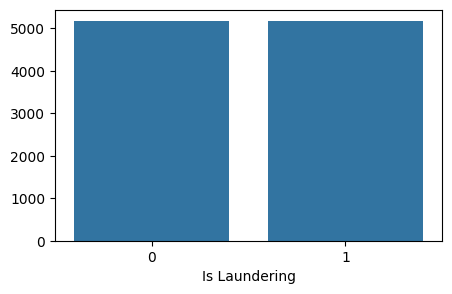

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
y= df['Is Laundering']
X= df.drop(['Is Laundering'],axis = 1)

# under sample data for data imbalance
from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler()
X,y=undersampler.fit_resample(X,y)

# plot the data
new_distribution=y.value_counts()
plt.figure(figsize=(5,3))
sns.barplot(x=new_distribution.index,y=new_distribution.values)

# plot some relations

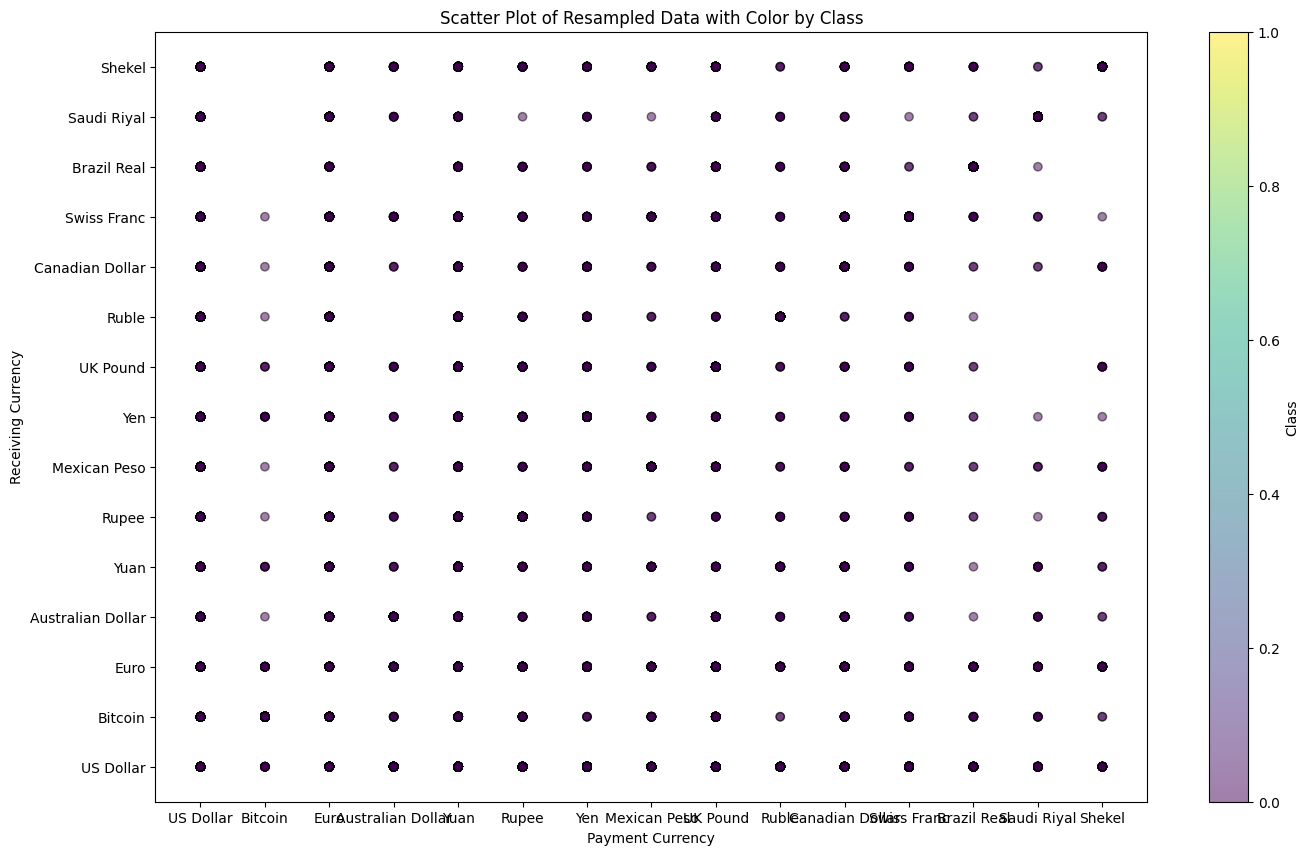

In [10]:
import matplotlib.pyplot as plt
# Assuming transactions is your DataFrame
plt.figure(figsize=(16, 10))
plt.scatter(
    df['Payment Currency'],
    df['Receiving Currency'],
    c=df['Is Laundering'],
    cmap='viridis',
    alpha=0.5,
    edgecolor='k'
    )
plt.xlabel('Payment Currency')
plt.ylabel('Receiving Currency')
plt.title('Scatter Plot of Resampled Data with Color by Class')
plt.colorbar(label='Class')
plt.show()

Chi-square test

Null Hypothesis (H₀):

There is no association between the categorical variables.

Alternative Hypothesis (H₁):

There is an association between the categorical variables.

In [11]:
cat=[]
for i in df.columns:
    if df[i].dtype == 'object':
        cat.append(i)
from scipy.stats import chi2_contingency
for i in cat:
    chi2, pval, _, _ = chi2_contingency(pd.crosstab(X[i], y))
    print(i, '---', pval)

Timestamp --- 2.148472988051235e-06
Account --- 8.159877731696627e-22
Account.1 --- 7.627342922966155e-18
Receiving Currency --- 2.2443480215740596e-58
Payment Currency --- 2.151372380680924e-59
Payment Format --- 0.0


# Check for multi colinearity in numerical data

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF for numerical columns
numeric_columns = []
for i in X.columns:
    if X[i].dtype != 'object' :
        numeric_columns.append(i)

# VIF sequentially check

vif_data = X[numeric_columns]
total_columns = vif_data.shape[1]
columns_to_be_kept = []
column_index = 0

for i in range (0,total_columns):

    vif_value = variance_inflation_factor(vif_data, column_index)
    print (numeric_columns[column_index],'---',vif_value)


    if vif_value <= 6:
        columns_to_be_kept.append( numeric_columns[i] )
        column_index = column_index+1

    else:
        vif_data = vif_data.drop([ numeric_columns[i] ] , axis=1)

From Bank --- 1.2474561315445907
To Bank --- 1.2476418616258866
Amount Received --- 15591.688218630557
Amount Received --- 1.0001679368077543


# Feature engineering:

# Drop unwanted columns

In [13]:
X= X.drop(["Amount Paid",
           "Account.1",
           "Account"
           ],axis =1)

# Convert time stamp to date

In [14]:
X["Timestamp"] = pd.to_datetime(X["Timestamp"])

# Extract Date, Day, and Time from the Timestamp
X["Date"] = X["Timestamp"].dt.date
X["Day"] = X["Timestamp"].dt.day_name()
X["Time"] = X["Timestamp"].dt.time

X.drop(columns=["Timestamp"], inplace=True)

# Pipeline setting:

# Train test split

In [15]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

# Pipeline

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

categorical = [
    'From Bank',
    'To Bank',
    'Receiving Currency',
    'Payment Currency',
    'Payment Format',
    'Day']
ohe = Pipeline([(
'Encoder',
OneHotEncoder(drop = 'first',handle_unknown='ignore'))
])

from sklearn.compose import ColumnTransformer
transformer = ColumnTransformer([('One Hot Encoding',ohe,categorical)])

from xgboost import XGBClassifier
# Define the full pipeline without the undersampler
model = Pipeline([
    ('Transformer', transformer),           # Preprocess the data
    ('Estimator', XGBClassifier())          # Train the model with XGBoost
])
model.fit(X_train,y_train)

Pipeline(steps=[('Transformer',
                 ColumnTransformer(transformers=[('One Hot Encoding',
                                                  Pipeline(steps=[('Encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['From Bank', 'To Bank',
                                                   'Receiving Currency',
                                                   'Payment Currency',
                                                   'Payment Format',
                                                   'Day'])])),
                ('Estimator',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsamp...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

# Evaluation

In [17]:
y_pred = model.predict(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


<Figure size 800x600 with 0 Axes>

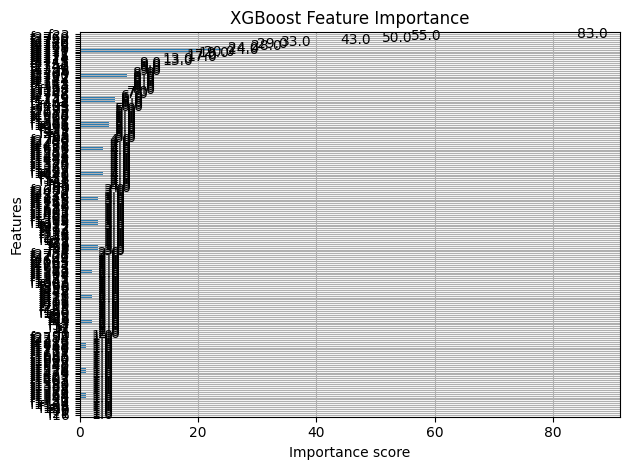

In [19]:
# get the trained XGBoost model from the pipeline
xgb_model = model.named_steps['Estimator']

import matplotlib.pyplot as plt
from xgboost import plot_importance

plt.figure(figsize=(8,6))
plot_importance(xgb_model)
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()


Text(0.5, 23.52222222222222, 'Predicted Values')

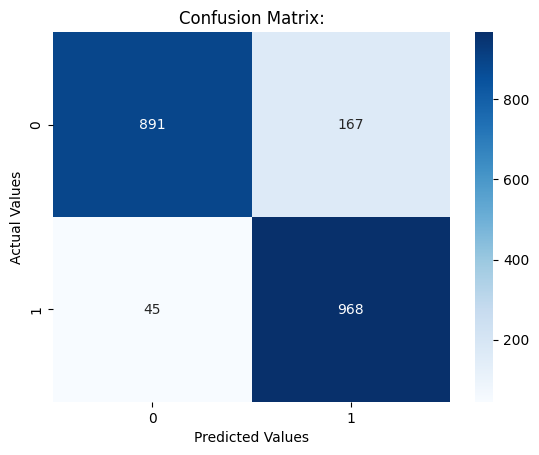

In [20]:
from sklearn.metrics import confusion_matrix
plt.title("Confusion Matrix:")
cm=confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues")
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")

In [21]:
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.84      0.89      1058
           1       0.85      0.96      0.90      1013

    accuracy                           0.90      2071
   macro avg       0.90      0.90      0.90      2071
weighted avg       0.90      0.90      0.90      2071



In [22]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
print("Accuracy Score:", accuracy_score(y_test, y_pred)*100)
print("Precision Score:",precision_score(y_test, y_pred)*100)
print("Recall Score:",recall_score(y_test, y_pred)*100)
print("F1 Score:", f1_score(y_test, y_pred)*100)

Accuracy Score: 89.76339932399807
Precision Score: 85.2863436123348
Recall Score: 95.55774925962488
F1 Score: 90.13035381750466
